In [3]:
from textrazor import TextRazor
from collections import defaultdict, Counter, OrderedDict
import json
import re
import operator
import string
import numpy as np
import math
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import nltk.data
import pandas as pd
from tabulate import tabulate

In [110]:
## Functions Definitions ##

def get_top_relevant_topics(response, thresh_score):
    top_relevant_topics = []
    topics = []
    topics = response.topics()
    top_relevant_topics = [topic for topic in topics if topic.score > thresh_score]

    return top_relevant_topics
    #for topic in top_relevant_topics:
    #print(topic.label, topic.score)

In [4]:
#Using text razor to get the topic type
# Currently used - entities
def createKeywordsFile(fileName):
    rashkey = "cc9e748f39591c90171653b1ded93c6bd2b8a3da262b3a116aa6524d"
    outPutFileName = fileName+"-entities.txt"
    client = TextRazor( "fdd39e9dde7d84983bbe964c514035f3c483d7df5996f62541ef76bc",
                       extractors=["entities"])
    outputFile = open(outPutFileName, "w")
    outPutFileName = "entityStore.txt"
    file = open(fileName, 'r')
    for line in file:
        sentence = line
        response = client.analyze(sentence)
        entityList = []
        for entity in response.entities():
            entityList.append(entity.matched_text)
        entityList = list(set(entityList))
        sentenceModified = ' '.join(entityList)
        outputFile.write(sentenceModified)
        outputFile.write("\n")
    outputFile.close()
    return outPutFileName

In [5]:
# Method to load data from the file
def loadData(fileName, stopWords, train=True):
    ctf_data = defaultdict(int)
    df_data = defaultdict(int)
    f = open(fileName)
    data = []
    cnt = 0

    tokensFile = open("tokens.dat", "w")

    # Calling method that yield every 1000 lines of file
    for l in printer(f, 10000, "%d lines"):

        text = l

        # Calls the tokenize method
        terms = Counter(tokenize(text))

        # Removes stop words
        for term in stopWords:
            if (terms.get(term)):
                terms.pop(term)

        # Create the ctf and df dictionaries
        for key, value in terms.items():
            df_data[key] += 1
            ctf_data[key] += value

        # Create the term list
        data.append(terms)

        cnt = cnt + 1
        if cnt % 100000 == 0:
            # Write to token file
            for d in data:
                json.dump(d, tokensFile)
                tokensFile.write("\n")

            data = []

    if cnt % 100000 != 0:
        for d in data:
            json.dump(d, tokensFile)
            tokensFile.write("\n")

    tokensFile.close()



    # Sort ctf and df dictionaries by values
    ctf_data = OrderedDict(sorted(ctf_data.items(), key=operator.itemgetter(1), reverse=True))

    df_data = OrderedDict(sorted(df_data.items(), key=operator.itemgetter(1), reverse=True))

    # Store values in file
    with open("ctf.dat", "w") as ctf_file:
        json.dump(ctf_data, ctf_file)

    with open("df.dat", "w") as df_file:
        json.dump(df_data, df_file)

    return ctf_data, df_data


In [6]:
def tokenize(text):
    regex = re.compile("\S*\d\S*")
    for c in string.punctuation:
        text = text.replace(c, "")

    text = regex.sub('', text)
    text = text.lower().split()

    return text

#Method to print the number of features traversed
def printer(X, n, stmt):
    count = 0
    for  x in X:
        count += 1
        if count % n == 0:
            print (stmt % count)
        yield x

In [7]:
#Method to design features
def featureDesign(N):

    fd = open("ctf.dat")
    fdf = open("df.dat")


    file = fd.read()
    dic = json.loads(file)
    fd.close()

    file = fdf.read()
    dic_df = json.loads(file)
    fdf.close()

    topk = 2000
    #Modify dictionary to sort it
    dic_mod = OrderedDict(sorted(dic.items(), key=operator.itemgetter(1), reverse=True))
    dic_mod = dict(dic_mod)
    #Fethc top 2000 terms
    top_terms = list(dic_mod.keys())[:topk]

    f = open("tokens.dat")

    data = np.zeros((N, topk))
    term_index = list(enumerate(top_terms))
    term_index = OrderedDict(reverse(term_index))
    top_terms_set = set(top_terms)


    for index, line in enumerate(f):
        terms = json.loads(line)
        #Find the top 2000 terms
        intersection_terms = top_terms_set.intersection(set(terms.keys()))
        for term in intersection_terms:
            # implementation of tf-idf
            a = terms[term] + 1
            b = (N+1-dic_df[term])
            c = (dic_df[term]+1)
            d = b/float(c)
            d = d+2
            e = math.log(d)
            f = a * e
            data[index][term_index[term]] = a * e

    return data

In [8]:
#Returns the dictionary as value,key
def reverse(dic):
    for k,v in dic:
        yield v,k

In [9]:
#Kmeans clustering method
def kMeans(X):
    kmeans = KMeans(n_clusters=15, random_state=0).fit(X)
    labels = kmeans.labels_
    return labels
    indices = {}
    for l in range(0,11):
        indices[l] = [i for i, x in enumerate(labels) if x == l]
    for l in range(0,11):
        print(str(l)+":"+ str(len(indices[l])))
    print(indices)

    return indices

In [10]:
def readMainTerms():
    tokensFile = open("tokens.dat", "r")
    tokdi = {}
    i = 1
    for t in tokensFile:
        tokdi[i] = t
        i = i + 1
    return tokdi

In [11]:
def visualize(df):
    groups = df.groupby('cluster')
    fig, ax = plt.subplots(figsize=(17, 9))  # set size
    ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group, marker='o', linestyle='', ms=12,mec='none')
        ax.set_aspect('auto')
        ax.tick_params( \
            axis='x',  # changes apply to the x-axis
            which='both',  # both major and minor ticks are affected
            bottom='off',  # ticks along the bottom edge are off
            top='off',  # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params( \
            axis='y',  # changes apply to the y-axis
            which='both',  # both major and minor ticks are affected
            left='off',  # ticks along the bottom edge are off
            top='off',  # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  # show legend with only 1 point


    plt.show()  # show the plot

                                                 terms  cluster
1                                        {"down": 1}\n        0
2           {"department": 1, "of": 1, "defense": 1}\n        2
3                                       {"roger": 1}\n        0
4                                                 {}\n        0
5           {"mojave": 1, "desert": 1, "xplanes": 1}\n        0
6                                                 {}\n        0
7                    {"us": 1, "next": 1, "year": 1}\n        0
8                                                 {}\n        0
9                                                 {}\n        0
10                                        {"god": 1}\n        0
11                                                {}\n        0
12                                                {}\n        0
13     {"america": 1, "aerospace": 1, "dogfight": 1}\n        0
14                                                {}\n        0
15                                      

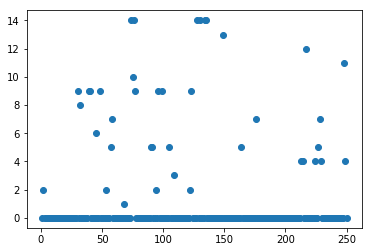

In [20]:
if __name__=="__main__":
    #outFile = createKeywordsFile("annotationFile")
    outFile = "annotationFile-entities.txt"
    N = 250 #Change this
    #stopWords = list(set(stopwords.words('english')))
    stopWords = []
    #ctf, df = loadData(outFile, stopWords, True)
    features = featureDesign(N)
    labels = kMeans(features)
    terms = readMainTerms()
    i = range(1,N+1)
    topics = {'terms': terms, 'cluster': labels}
    frame = pd.DataFrame(topics, index=i, columns=['terms', 'cluster'])
    print(frame)
    plt.scatter(frame.index, frame['cluster'])
    plt.show()
    #visualize(frame)

In [21]:
#Count of sentences in each cluster
frame['cluster'].value_counts()

0     210
9       8
14      6
5       6
4       5
2       4
7       3
13      1
12      1
11      1
10      1
8       1
6       1
3       1
1       1
Name: cluster, dtype: int64

In [131]:
frame['sentence'] = frame.index
with pd.option_context('display.max_rows', 251, 'display.max_columns', 3):
    display(frame)

,terms,cluster,sentence
1,"{""down"": 1}\n",0,1
2,"{""department"": 1, ""of"": 1, ""defense"": 1}\n",2,2
3,"{""roger"": 1}\n",0,3
4,{}\n,0,4
5,"{""mojave"": 1, ""desert"": 1, ""xplanes"": 1}\n",0,5
6,{}\n,0,6
7,"{""us"": 1, ""next"": 1, ""year"": 1}\n",0,7
8,{}\n,0,8
9,{}\n,0,9
10,"{""god"": 1}\n",0,10


In [70]:
topic_cluster_list = list(frame['sentence'].groupby(frame['cluster']))

In [132]:
#Find topics of segmented text after clustering
def topicsInCluster():
    #Source file for finding topics in clustered results
    inFile = open("annotationFile", encoding='utf8').read()
    outPutFileName = "clusterTopics_BattleOfXPlanes.txt"
    outputFile = open(outPutFileName, "w")
    #sher_key = "fdd39e9dde7d84983bbe964c514035f3c483d7df5996f62541ef76bc"
    client = TextRazor("fdd39e9dde7d84983bbe964c514035f3c483d7df5996f62541ef76bc", extractors=["topics"])

    #Group the cluster results by cluster number
    frame['sentence'] = frame.index
    topic_cluster_list = list(frame['sentence'].groupby(frame['cluster']))

    for element in topic_cluster_list:
        text = "\n"
        print("\nCluster " , element[0])
        print("Sentences\n",(element[1]) )
        for index_val, series_val in element[1].iteritems():
            print (series_val)
            print(inFile.splitlines()[series_val-1])
            text = text + inFile.splitlines()[series_val-1] + " "
        print("Text: ********************",text)
        response = client.analyze(text)
        print("Writing to file")
        outputFile.write("\n\nCluster number: ")
        outputFile.write(str(element[0]))
        outputFile.write("\n")
        outputFile.write(text)
        outputFile.write("\n")  
        topics = []
        topics = get_top_relevant_topics(response, 0.5)
        if len(response.topics()) == 0:
            outputFile.write(">> no topics were found")


        elif len(topics) ==0:
            outputFile.write(">> no relevant topics with high confidence score were found")

        else:
            outputFile.write(">> Top relevant topics:\n")
            for topic in topics:
                 outputFile.write("\n"+ topic.label +": "+ str(topic.score))
    outputFile.close()


In [133]:
topicsInCluster()


Cluster  0
Sentences
 1        1
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
12      12
13      13
14      14
15      15
16      16
17      17
18      18
19      19
20      20
21      21
22      22
23      23
24      24
25      25
26      26
27      27
28      28
29      29
31      31
33      33
      ... 
212    212
215    215
216    216
218    218
219    219
220    220
221    221
222    222
223    223
225    225
226    226
230    230
231    231
232    232
233    233
234    234
235    235
236    236
237    237
238    238
239    239
240    240
241    241
242    242
243    243
244    244
245    245
246    246
247    247
250    250
Name: sentence, Length: 210, dtype: int64
1
Three, two, one, down
3
Roger, copy that
4
Just for the record, pilot, yeah? You are my hero.
5
In the skies over the Mojave Desert a battle of X-planes has begun.
6
That looks good.
7
Over the next year, two different planes will take to the skies again and aga

Writing to file

Cluster  1
Sentences
 68    68
Name: sentence, dtype: int64
68
Almost all of America's fighters will one day wind up here at the boneyard at Davis-Monthan Air Force Base in Arizona.
Text: ******************** 
Almost all of America's fighters will one day wind up here at the boneyard at Davis-Monthan Air Force Base in Arizona. 
Writing to file

Cluster  2
Sentences
 2        2
53      53
94      94
122    122
Name: sentence, dtype: int64
2
We're here today to announce the largest acquisition program in the history of the Department of Defense
53
NOVA and the Department of Defense have cleared you to enter places where cameras have never gone before, from secret installations to the cockpits of the latest experimental fighters.
94
In the sixties, when the cost-cutting Secretary of Defense, Robert McNamara, forced the Navy and Air Force to use the same plane, the F-111, the joint program was a resounding flop.
122
And that's a lot of money in anybody's calculus, even in 

Writing to file

Cluster  10
Sentences
 75    75
Name: sentence, dtype: int64
75
While it remains the only successful vertical landing fighter, it dates back to the British invasion of America by the Beatles.
Text: ******************** 
While it remains the only successful vertical landing fighter, it dates back to the British invasion of America by the Beatles. 
Writing to file

Cluster  11
Sentences
 248    248
Name: sentence, dtype: int64
248
Think of taking the propulsion system in a Navy Destroyer, shrinking that down into a smaller package, putting it into a jet fighter airplane.
Text: ******************** 
Think of taking the propulsion system in a Navy Destroyer, shrinking that down into a smaller package, putting it into a jet fighter airplane. 
Writing to file

Cluster  12
Sentences
 217    217
Name: sentence, dtype: int64
217
By the time Lockheed earns its place in the final JSF competition, Chief Engineer Rick Rezabek and his team have already spent five years designing the